In [90]:
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate

import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import GammaX_toyMC
import importlib

%matplotlib inline
%config InlineBackend.figure_format='retina'

textSize = 18
params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': textSize,
          'axes.titlesize': textSize,
          'xtick.labelsize': textSize,
          'ytick.labelsize': textSize}
histKwargs = {'histtype': 'step', 'linewidth': 3}
plt.rcParams.update(params)

# 2D Toy MC Model to Test Importance Sampling

## Testing the Compton algorithm

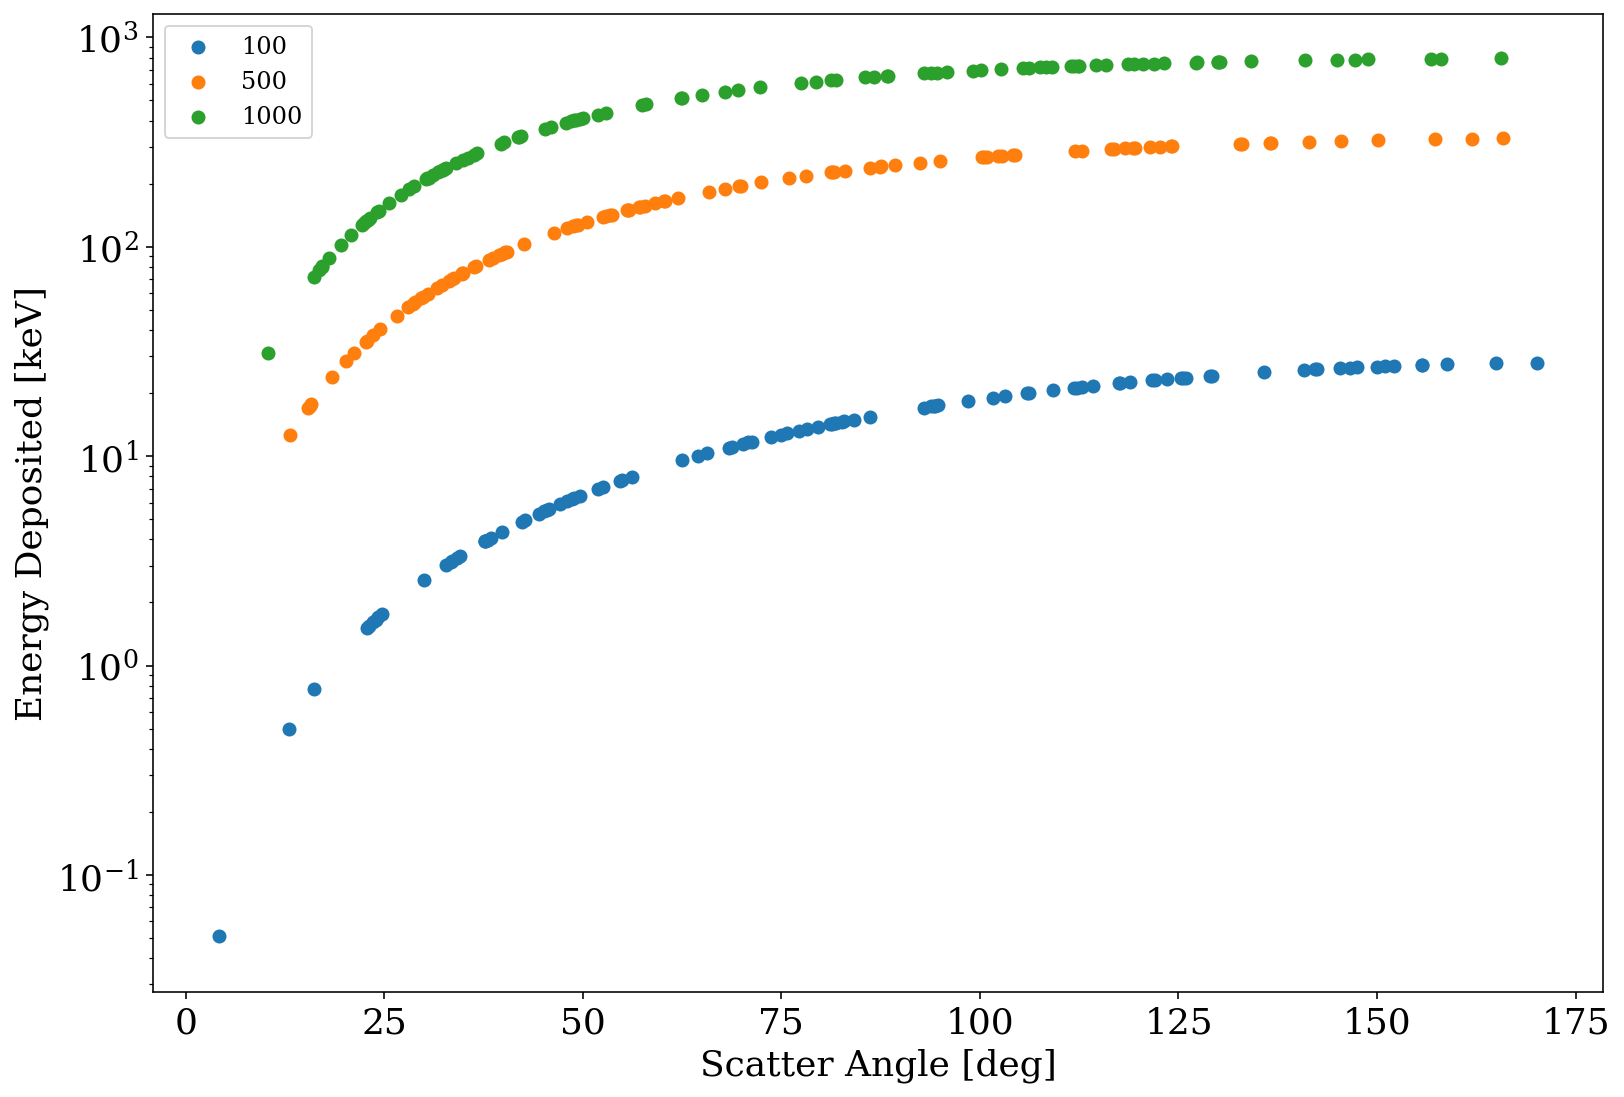

In [94]:
for e in [100, 500, 1000]:
    eDeps, phis = GammaX_toyMC.comptonAlgorithm(np.full(shape = 100, fill_value = e))
    plt.scatter(phis * 180 / np.pi, eDeps, label = str(e))
plt.legend()
plt.xlabel('Scatter Angle [deg]')
plt.ylabel('Energy Deposited [keV]')
plt.yscale('log')
plt.show()

## Comparing different FVs

In [92]:
%%time

Es = np.linspace(200, 500, 50) # Energies in keV
rates = []
frates = []
ffrates = []
for e in Es:
    y0, y1, y2, Edep0, Edep1 = GammaX_toyMC.returnTracks(100_000, e)
    rates.append(GammaX_toyMC.getGXRate(0, y1, y2))
    frates.append(GammaX_toyMC.getGXRate(1, y1, y2))
    ffrates.append(GammaX_toyMC.getGXRate(2, y1, y2))

CPU times: user 9.3 s, sys: 599 ms, total: 9.9 s
Wall time: 4.96 s


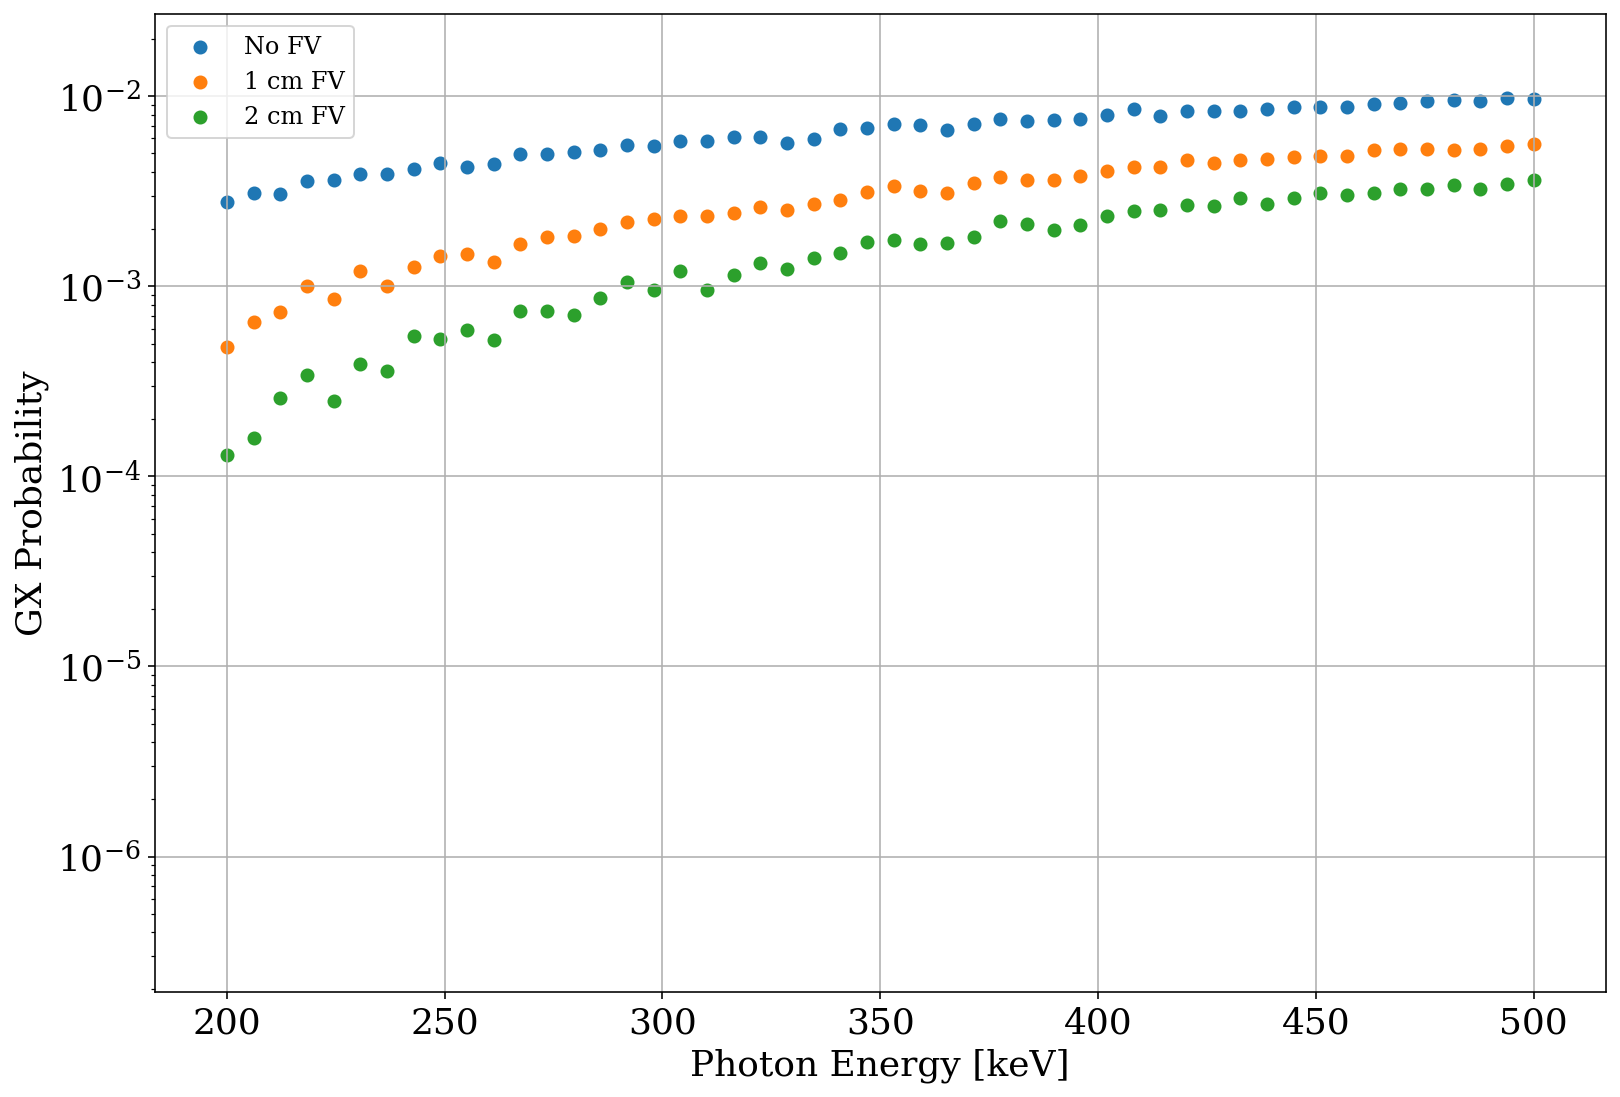

In [93]:
plt.scatter(Es, rates, label = 'No FV')
plt.scatter(Es, frates, label = '1 cm FV')
plt.scatter(Es, ffrates, label = '2 cm FV')


plt.yscale('log')
plt.xlabel('Photon Energy [keV]')
plt.ylabel('GX Probability')
plt.legend()
plt.grid()
plt.show()

Trends agree with expectation

## Does IS work?

In [95]:
%%time

Es = np.linspace(200, 500, 50)
rates = []
ISrates = []

for e in Es:
    y0, y1, y2, Edep0, Edep1 = GammaX_toyMC.returnTracks(50_000, e)
    y0IS, y1IS, y2IS, Edep0, Edep1 = GammaX_toyMC.returnTracks(100_000, e, lengthImportanceRegion = 5, IS_factor = 4, sampling = True)

    rates.append(GammaX_toyMC.getGXRate(1, y1, y2))
    ISrates.append(GammaX_toyMC.getGXRate(1, y1IS, y2IS))

CPU times: user 16.7 s, sys: 1.25 s, total: 18 s
Wall time: 8.99 s


In [96]:
plt.scatter(Es, rates, label = 'Analog')
plt.scatter(Es, ISrates, label = 'Importance Sampled')

plt.yscale('log')
plt.xlabel('Photon Energy [keV]')
plt.ylabel('GX Probability')
plt.legend()
plt.grid()
plt.show()

Definitely seems to work

### Timing of IS

In [100]:
numPoints = 50_000
energy = 200

In [101]:
%%timeit
_ = GammaX_toyMC.returnTracks(numPoints, energy, lengthImportanceRegion = 5, IS_factor = 2, sampling = True)

62.4 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
%%timeit
_ = GammaX_toyMC.returnTracks(numPoints, energy, lengthImportanceRegion = 5, IS_factor = 20, sampling = True)

65.5 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
%%timeit
_ = GammaX_toyMC.returnTracks(numPoints, energy, lengthImportanceRegion = 1, IS_factor = 2, sampling = True)

61.7 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
%%timeit
_ = GammaX_toyMC.returnTracks(numPoints, energy, lengthImportanceRegion = 1, IS_factor = 20, sampling = True)

66.2 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


No bottlenecks at a first glance...

### Grid search of hyperparameters 

In [106]:
def gridSearchIS(energy = 500, squareNum = 20, numPoints = 50_000, FVlength = 1):
    ISlengths = np.linspace(1, 10, squareNum)
    ISFactors = range(1, squareNum + 1)

    ratioResults = np.zeros((squareNum, squareNum))

    _, y1, y2, _, _ = GammaX_toyMC.returnTracks(numPoints, energy)
    noISRate = GammaX_toyMC.getGXRate(FVlength, y1, y2)

    for i in range(squareNum):
        for j in range(squareNum):
            _, y1IS, y2IS, _, _ = GammaX_toyMC.returnTracks(numPoints, energy, lengthImportanceRegion = ISlengths[i], IS_factor = ISFactors[j], sampling = True)
            ISRate = GammaX_toyMC.getGXRate(FVlength, y1IS, y2IS)
            ratioResults[i,j] = ISRate / noISRate
    
    return ratioResults

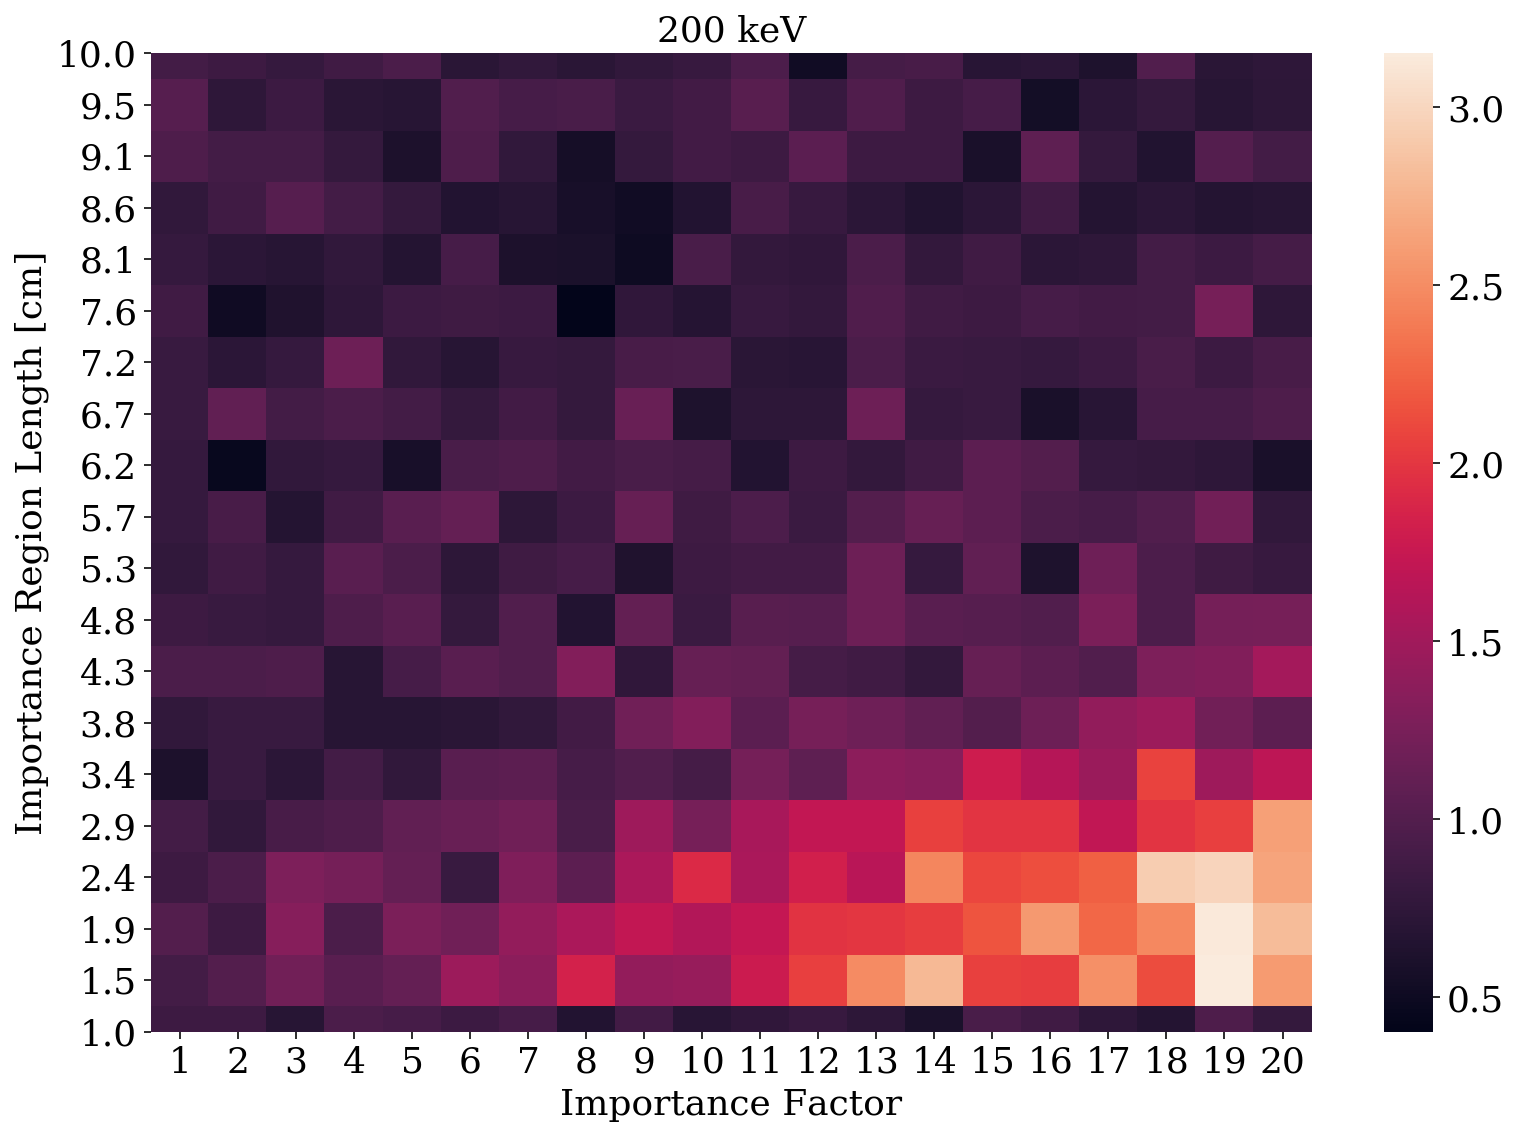

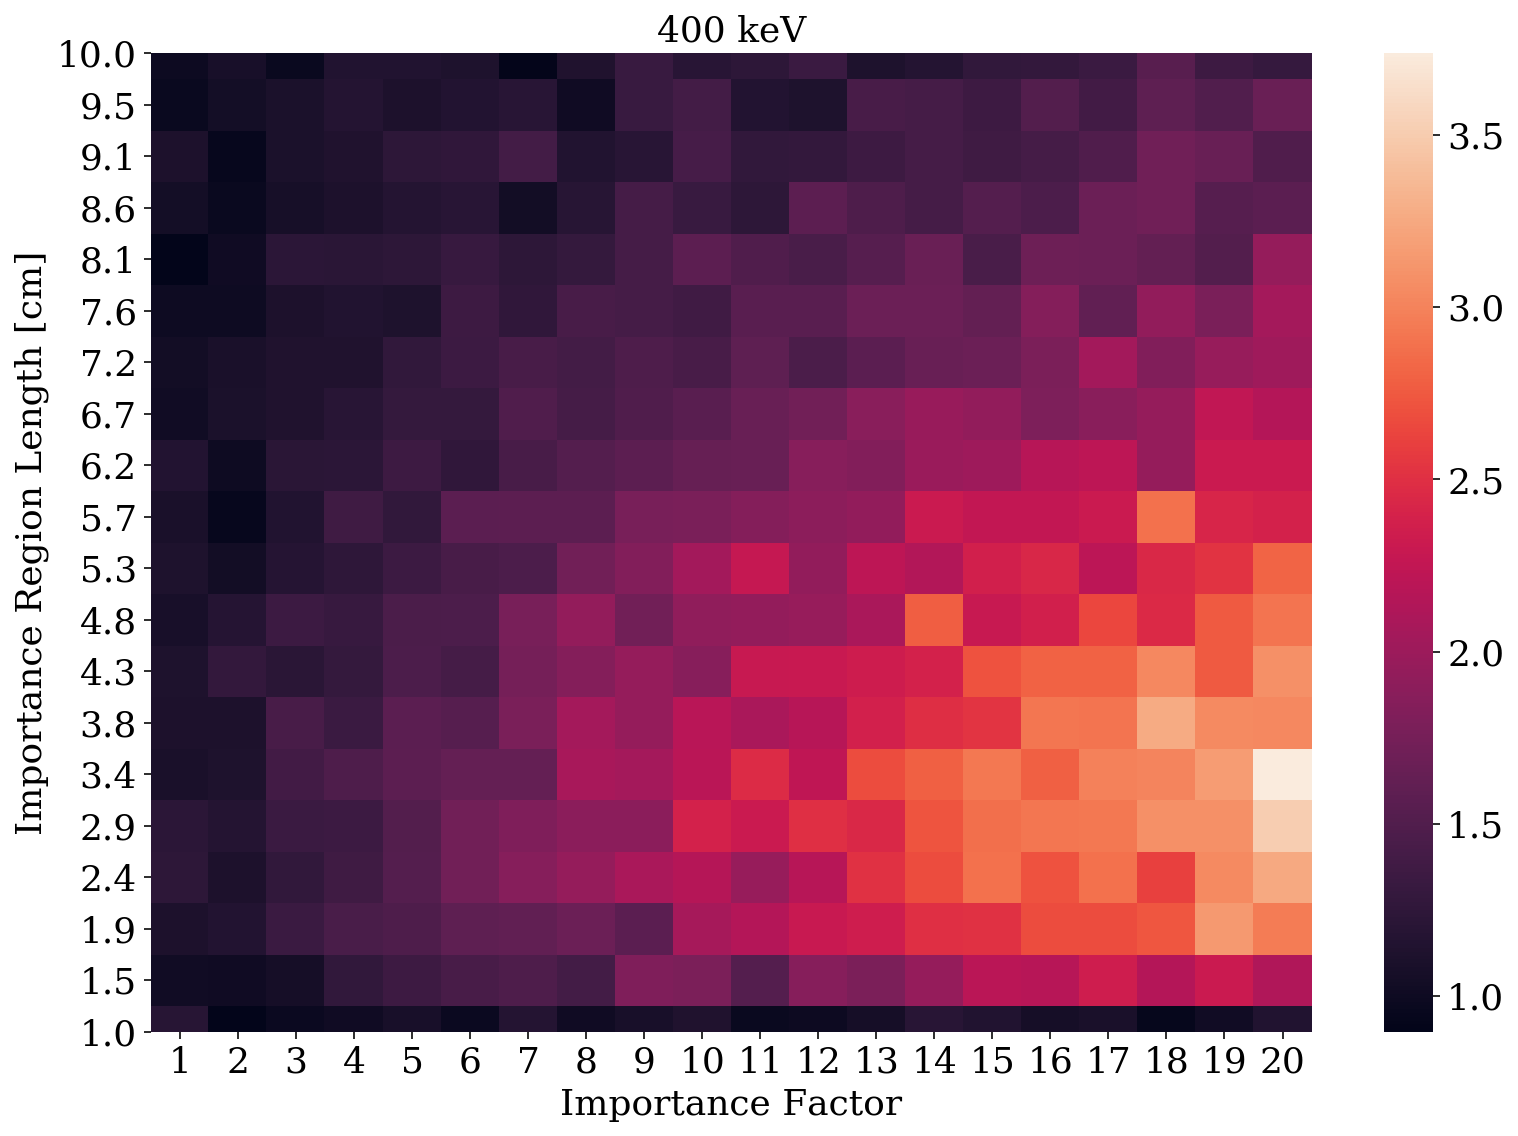

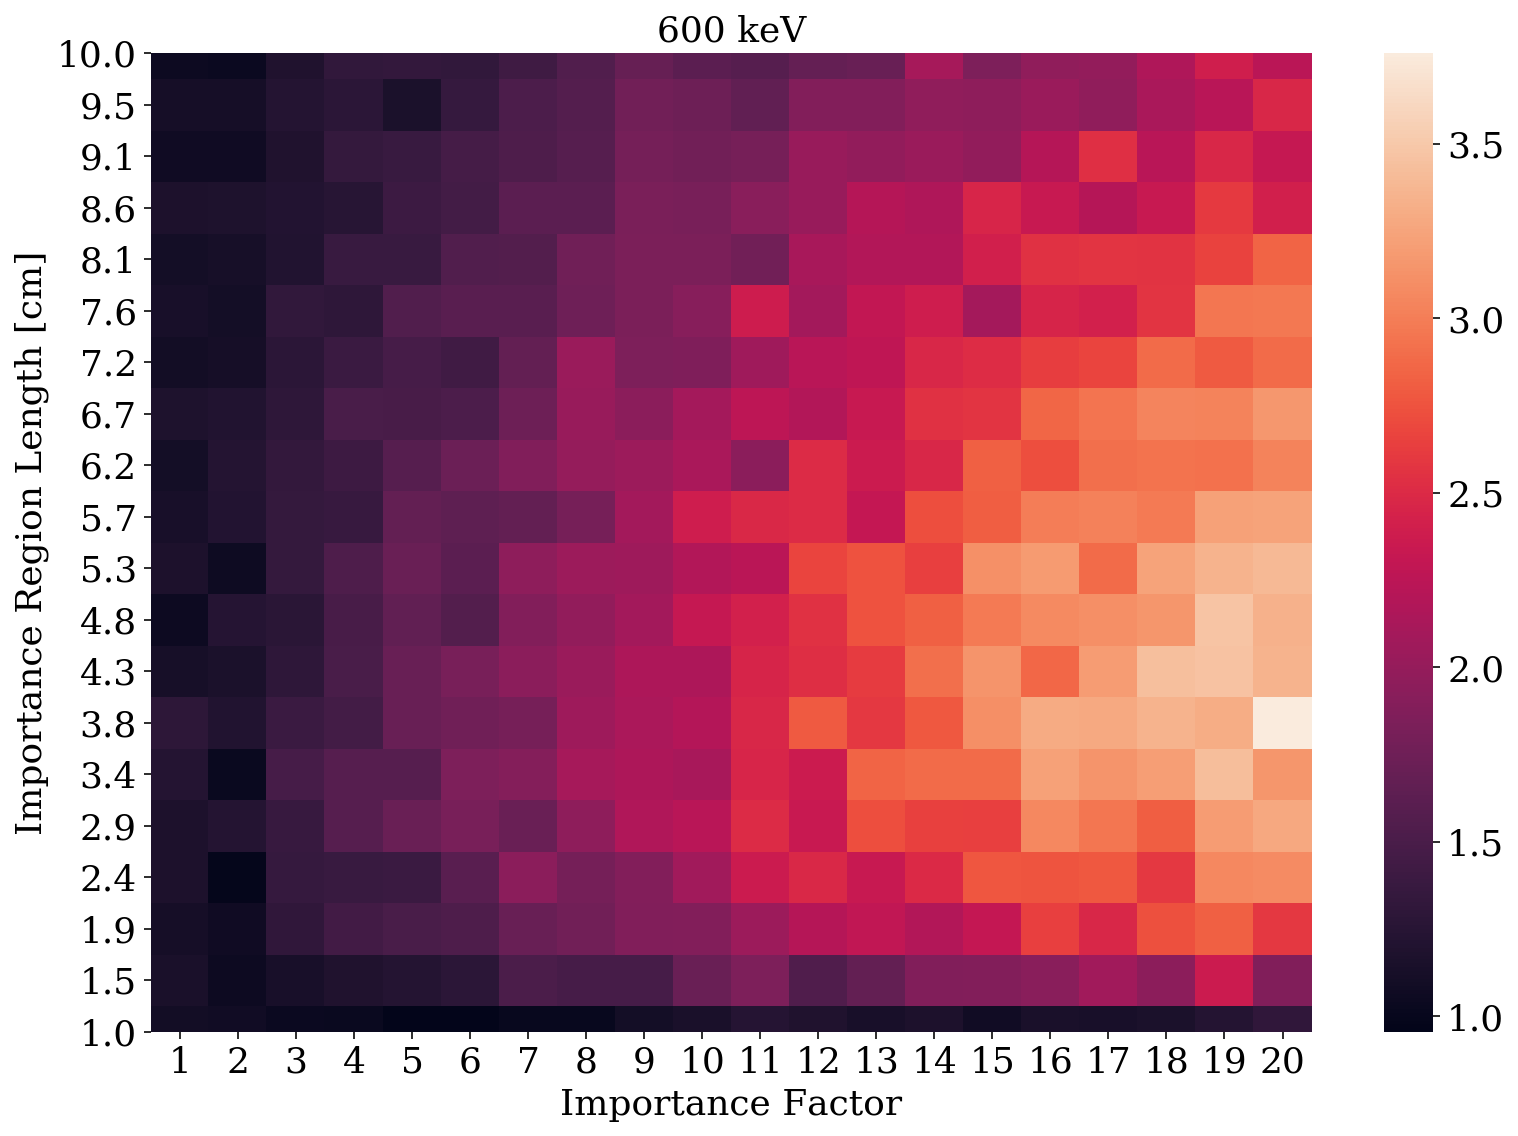

In [107]:
Es = np.arange(200, 700, 100)

squareNum = 20
ISlengths = np.linspace(1, 10, squareNum)
ISFactors = range(1, squareNum + 1)

for e in Es:
    ratioResults = gridSearchIS(e, squareNum, numPoints = 50_000)
    
    yticks = np.round(ISlengths, decimals = 1)
    xticks = ISFactors
    g1 = sns.heatmap(ratioResults, xticklabels = xticks, yticklabels = yticks)
    g1.invert_yaxis()
    plt.xlabel('Importance Factor')
    plt.ylabel('Importance Region Length [cm]')
    plt.title('{} keV'.format(e))
    plt.show()

## Testing more IS volumes

In [108]:
importlib.reload(GammaX_toyMC);

In [80]:
lengthRFR = 14 # [cm]
lengthDrift = 140 # [cm]
deadZoneInFV = (800 - 789) / 800 * 140 # [cm] gap between cathode and start of FV

The IS is extended to admit several geometric cells with different volumes. 
The most optimal configuration of weights is probably a two-pronged setup like shown.

Craft some good weight assignments.
We want scattering below the cathode, and above the FV, but want to downsample scattering in the dead region in between.

#### Symmetric Weights

In [109]:
deadZoneWeights = [1] * 10
lengthPerRegion = deadZoneInFV / len(deadZoneWeights)
numSideBins = 10
subCathodeWeights = [2**i for i in range(numSideBins)]
FVWeights = subCathodeWeights[::-1]

yB = - lengthPerRegion * len(subCathodeWeights)
yT = - yB + deadZoneInFV

iScores = subCathodeWeights + deadZoneWeights + FVWeights

_, edges, newScores = GammaX_toyMC.getTransitions(iScores, yB, yT, yDetectorBottom = -lengthRFR, yDetectorTop = lengthDrift)
GammaX_toyMC.plotScheme(newScores, edges, FV = deadZoneInFV)
plt.title('Symmetric Assignment')
plt.show()

In [111]:
%%time

Es = np.linspace(200, 500, 5)
numEvents = 500_000

rates = []
OGrates = []

for e in Es:
    _, y1IS, y2IS, _, _ = GammaX_toyMC.returnTracksIS(numEvents, e, iScores, yB = yB, yT = yT, yDetectorBottom = -lengthRFR, yDetectorTop = lengthDrift)
    _, y1OG, y2OG, _, _ = GammaX_toyMC.returnTracks(numEvents, e)
    
    rates.append(GammaX_toyMC.getGXRate(deadZoneInFV, y1IS, y2IS))
    OGrates.append(GammaX_toyMC.getGXRate(deadZoneInFV, y1OG, y2OG))

CPU times: user 2min 56s, sys: 10.4 s, total: 3min 6s
Wall time: 1min 37s


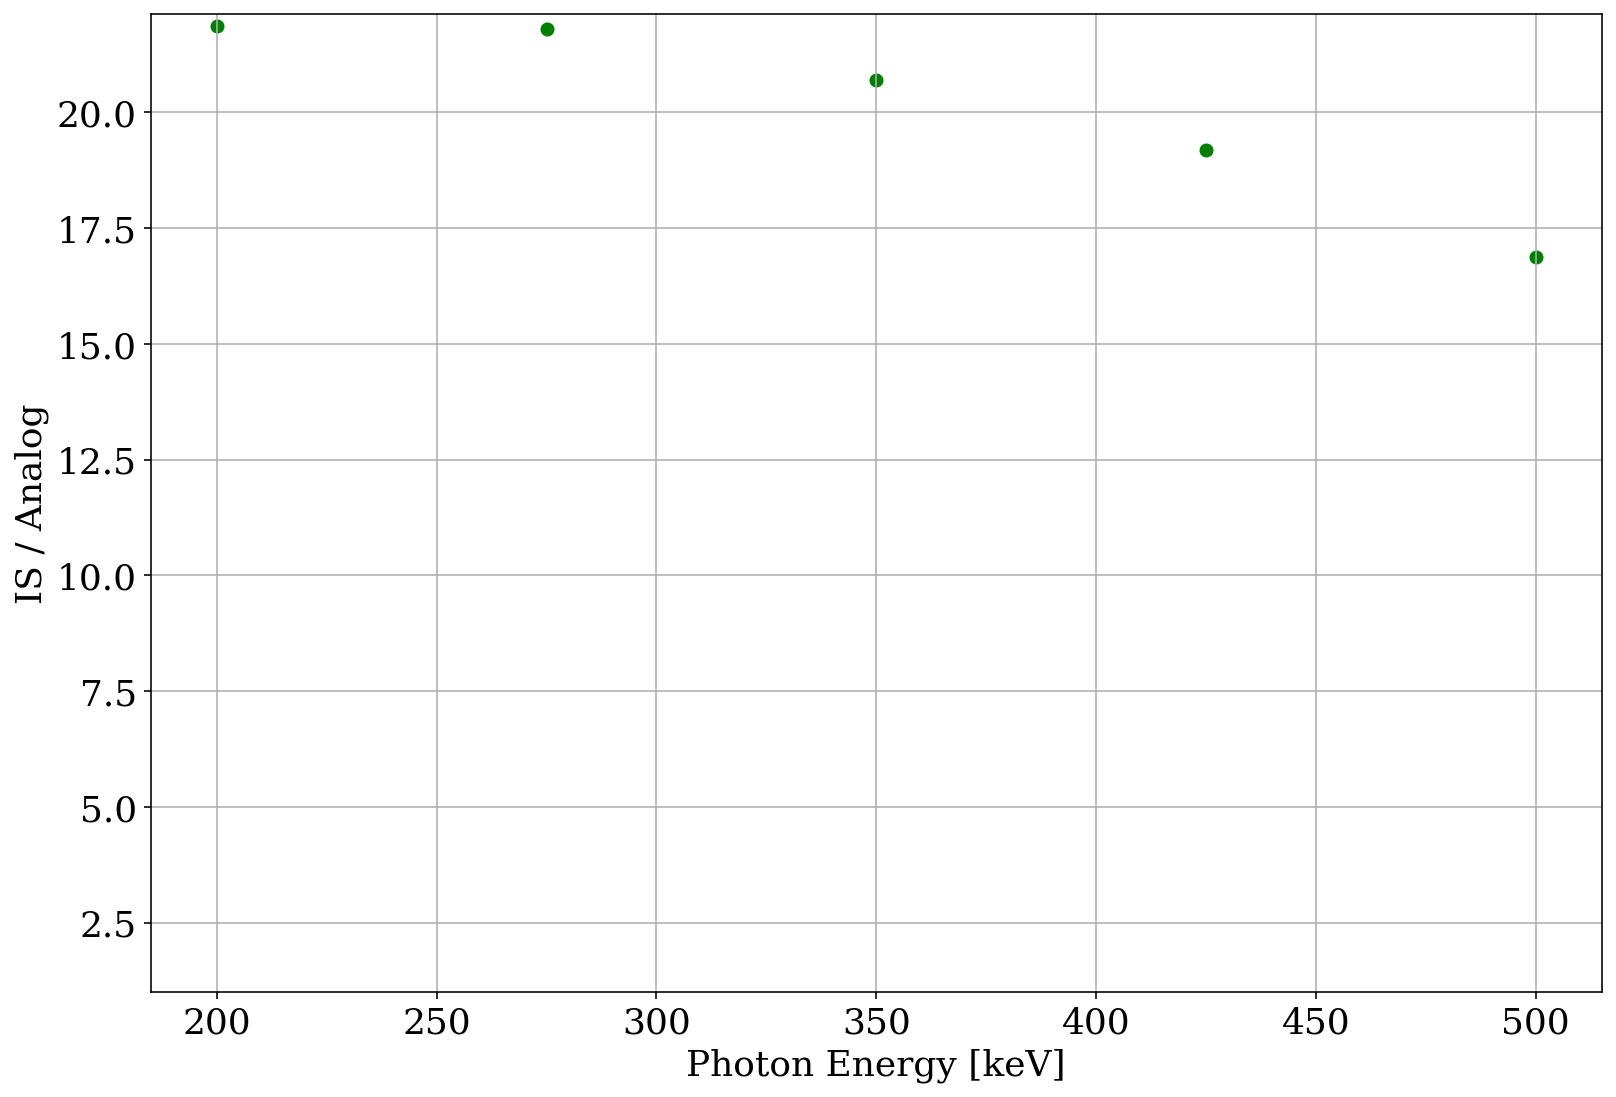

In [112]:
plt.scatter(Es, OGrates, label = 'Analog')
plt.scatter(Es, rates, label = 'Importance Sampled')

plt.xlabel('Photon Energy [keV]')
plt.ylabel('GX Events / Photons Tracked')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.scatter(Es, np.array(rates) / np.array(OGrates), color = 'green', label = 'ratio')
plt.xlabel('Photon Energy [keV]')
plt.ylabel('IS / Analog')
plt.ylim(1)
plt.grid()
plt.show()

### Optimal weights?

More than an order of magnitude enhancement is possible. Still, I am not sure if the optimal geometric weights were applied. 

With the two-pronged weights shown above, there is a steep penalty for scattering in the sub-FV region, but there is no upsampling for scatters that cross this region. 

However, if the weights are made asymmetric around the midpoint of the dead region, then a particular gX topology is favored. 

Another issue is that photons whose first scatter in the dead region, and cross either up or down for their second scatter, are very heavily upsampled. This is not ideal. 

#### Downscattering

In [85]:
deadZoneWeights = [1] * 10
lengthPerRegion = deadZoneInFV / len(deadZoneWeights)
numSideBins = 10
subCathodeWeights = [2**i for i in range(numSideBins)]
FVWeights = [2] * len(subCathodeWeights)

yB = - lengthPerRegion * len(subCathodeWeights)
yT = - yB + deadZoneInFV

iScores = subCathodeWeights + deadZoneWeights + FVWeights

_, edges, newScores = GammaX_toyMC.getTransitions(iScores, yB, yT, yDetectorBottom = -lengthRFR, yDetectorTop = lengthDrift)
GammaX_toyMC.plotScheme(newScores, edges, FV = deadZoneInFV)
plt.title('Downscattering Bias')
plt.show()

In [87]:
%%time

Es = np.linspace(200, 500, 10)
numEvents = 100_000

rates = []
OGrates = []

for e in Es:
    _, y1IS, y2IS, _, _ = GammaX_toyMC.returnTracksIS(numEvents, e, iScores, yB = yB, yT = yT, yDetectorBottom = -lengthRFR, yDetectorTop = lengthDrift)
    _, y1OG, y2OG, _, _ = GammaX_toyMC.returnTracks(numEvents, e)
    
    rates.append(GammaX_toyMC.getGXRate(deadZoneInFV, y1IS, y2IS))
    OGrates.append(GammaX_toyMC.getGXRate(deadZoneInFV, y1OG, y2OG))
    
plt.scatter(Es, OGrates, label = 'Analog')
plt.scatter(Es, rates, label = 'Importance Sampled')

plt.xlabel('Photon Energy [keV]')
plt.ylabel('GX Events / Photons Tracked')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.scatter(Es, np.array(rates) / np.array(OGrates), color = 'green', label = 'ratio')
plt.xlabel('Photon Energy [keV]')
plt.ylabel('IS / Analog')
plt.ylim(1)
plt.grid()
plt.show()

CPU times: user 19.3 s, sys: 604 ms, total: 19.9 s
Wall time: 15.1 s


What about upscatters? Don't expect a lot for this case, since there is not as much LXe in the RFR

#### Upscattering

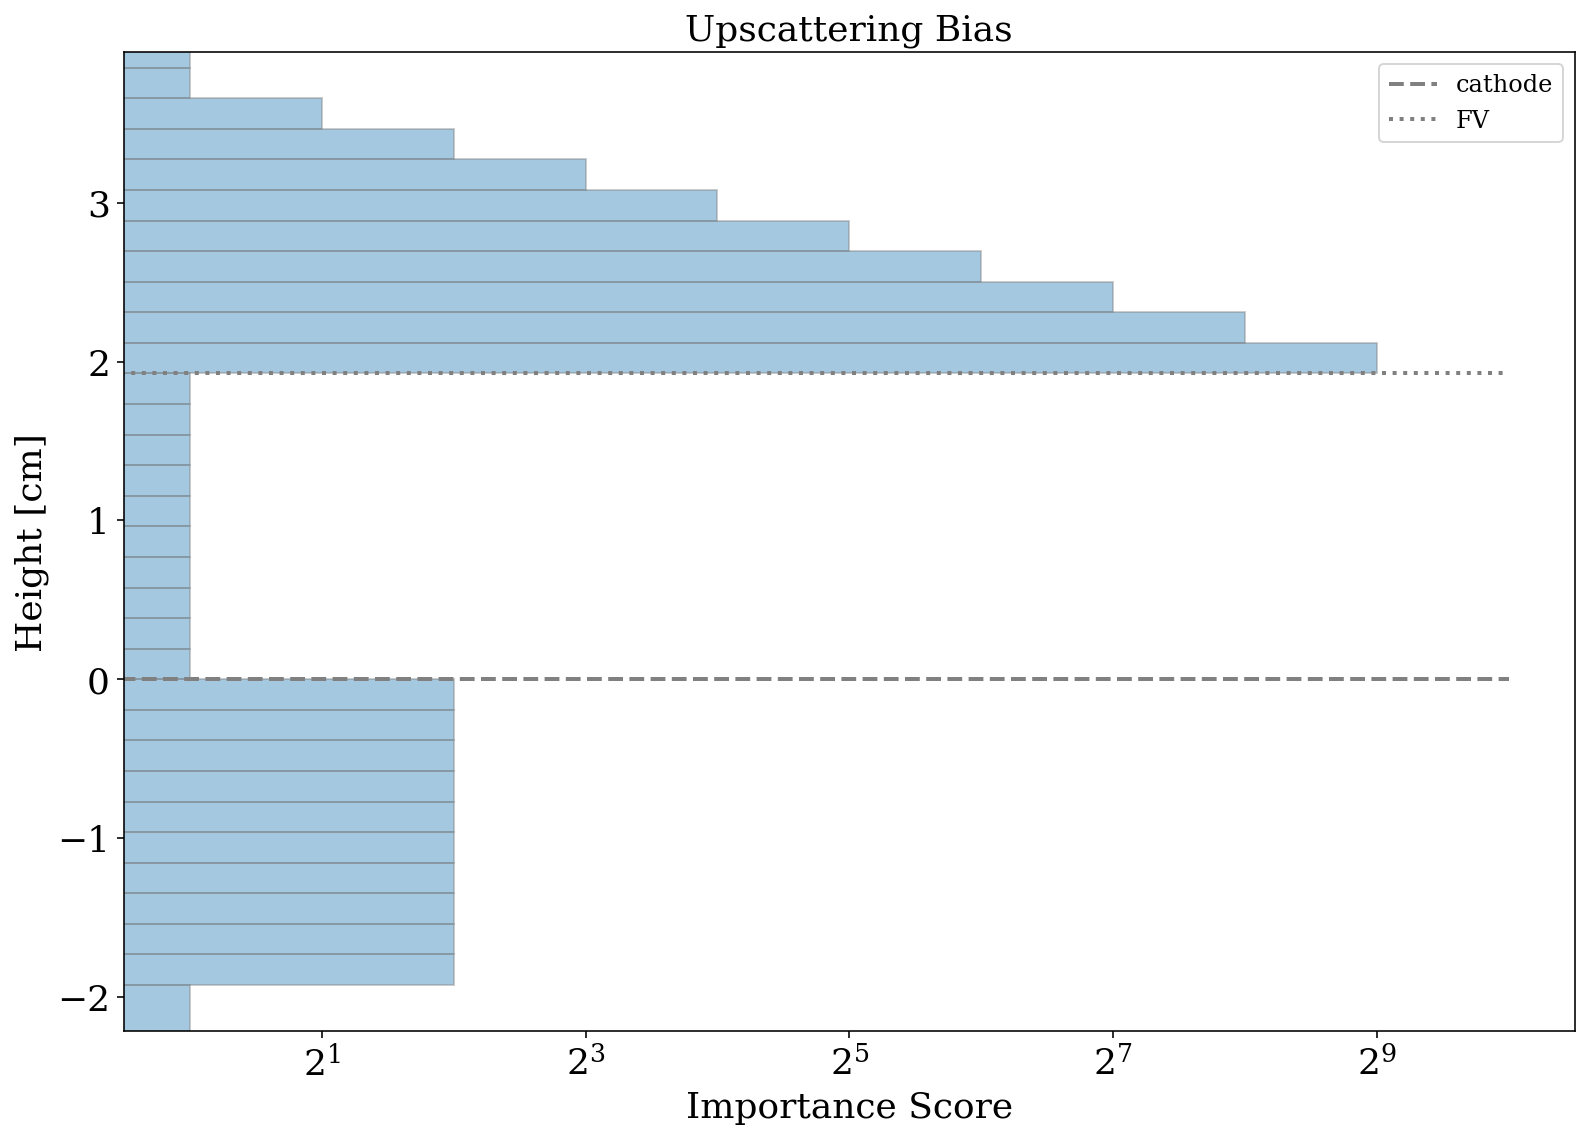

In [88]:
deadZoneWeights = [1] * 10
lengthPerRegion = deadZoneInFV / len(deadZoneWeights)
numSideBins = 10
subCathodeWeights = [4] * len(subCathodeWeights)
FVWeights = [2**i for i in range(numSideBins)][::-1]

yB = - lengthPerRegion * len(subCathodeWeights)
yT = - yB + deadZoneInFV

iScores = subCathodeWeights + deadZoneWeights + FVWeights

_, edges, newScores = GammaX_toyMC.getTransitions(iScores, yB, yT, yDetectorBottom = -lengthRFR, yDetectorTop = lengthDrift)
GammaX_toyMC.plotScheme(newScores, edges, FV = deadZoneInFV)
plt.title('Upscattering Bias')
plt.show()

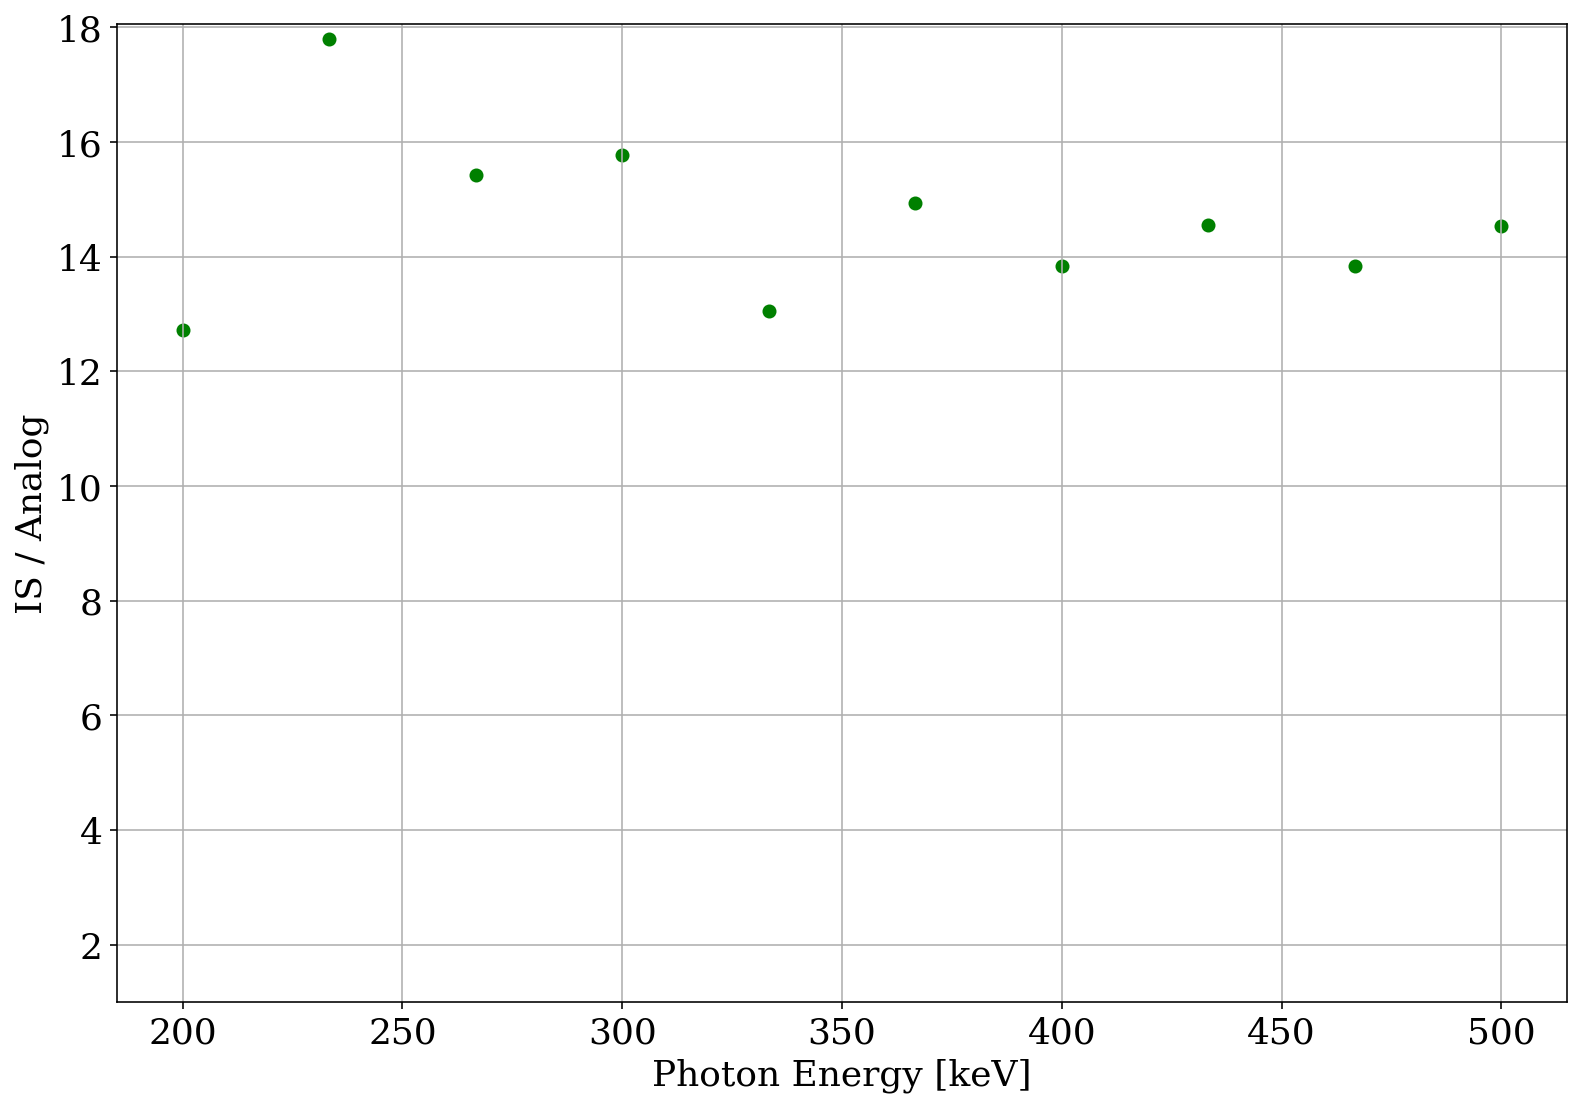

CPU times: user 18.8 s, sys: 513 ms, total: 19.4 s
Wall time: 14.6 s


In [89]:
%%time

Es = np.linspace(200, 500, 10)
numEvents = 100_000

rates = []
OGrates = []

for e in Es:
    _, y1IS, y2IS, _, _ = GammaX_toyMC.returnTracksIS(numEvents, e, iScores, yB = yB, yT = yT, yDetectorBottom = -lengthRFR, yDetectorTop = lengthDrift)
    _, y1OG, y2OG, _, _ = GammaX_toyMC.returnTracks(numEvents, e)
    
    rates.append(GammaX_toyMC.getGXRate(deadZoneInFV, y1IS, y2IS))
    OGrates.append(GammaX_toyMC.getGXRate(deadZoneInFV, y1OG, y2OG))
    
plt.scatter(Es, OGrates, label = 'Analog')
plt.scatter(Es, rates, label = 'Importance Sampled')

plt.xlabel('Photon Energy [keV]')
plt.ylabel('GX Events / Photons Tracked')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.scatter(Es, np.array(rates) / np.array(OGrates), color = 'green', label = 'ratio')
plt.xlabel('Photon Energy [keV]')
plt.ylabel('IS / Analog')
plt.ylim(1)
plt.grid()
plt.show()